<a href="https://colab.research.google.com/github/jin-honey/A-Disentangled-VAE-BiLSTM/blob/main/IF_SVM_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
## IF 데이터 라벨링

import pandas as pd
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.ensemble import IsolationForest

# 데이터 불러오기
file_path = '/content/drive/MyDrive/ss.csv'
data = pd.read_csv(file_path)


# 사용할 컬럼만 선택
features = data[["Sleep Duration", "BMI Category", "Blood Pressure", "Heart Rate", "Daily Steps"]].copy()

# Blood Pressure를 systolic/diastolic로 분리
features[["Systolic", "Diastolic"]] = features["Blood Pressure"].str.split("/", expand=True).astype(float)
features.drop("Blood Pressure", axis=1, inplace=True)

# 원-핫 인코딩: BMI Category
features = pd.get_dummies(features, columns=["BMI Category"], drop_first=True)

# 결측값 처리
features.fillna(features.mean(numeric_only=True), inplace=True)

# 정규화 (Min-Max Scaling)
scaler = MinMaxScaler()
features_scaled = scaler.fit_transform(features)

# Isolation Forest 적용
iso_forest = IsolationForest(n_estimators=100, contamination=0.1, random_state=42)
labels = iso_forest.fit_predict(features_scaled)

# 라벨 추가 (-1: 이상, 1: 정상)
data["Anomaly_Label"] = labels

# 결과 확인
print(data[["Person ID", "Anomaly_Label"]])

     Person ID  Anomaly_Label
0            1             -1
1            2             -1
2            3             -1
3            4             -1
4            5             -1
..         ...            ...
369        370              1
370        371              1
371        372              1
372        373              1
373        374             -1

[374 rows x 2 columns]


Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.97      0.98       106
           1       0.67      0.86      0.75         7

    accuracy                           0.96       113
   macro avg       0.83      0.91      0.87       113
weighted avg       0.97      0.96      0.97       113



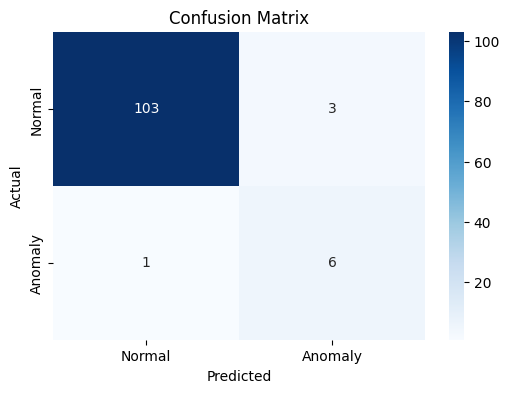

In [ ]:
## SVM 이상탐지

from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# 특성과 라벨 정의
X = features_scaled  # 이미 정규화된 데이터 사용
y = (data["Anomaly_Label"] == -1).astype(int)  # 이상: 1, 정상: 0

# 데이터 분할 (학습용: 70%, 테스트용: 30%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# SVM 분류기 정의 및 학습
svm_clf = SVC(kernel='rbf', gamma='scale', random_state=42)
svm_clf.fit(X_train, y_train)

# 예측
y_pred = svm_clf.predict(X_test)

# 평가 결과 출력
print("Classification Report:")
print(classification_report(y_test, y_pred))

# 혼동 행렬 시각화
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap="Blues", xticklabels=["Normal", "Anomaly"], yticklabels=["Normal", "Anomaly"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.97      0.98       106
           1       0.67      0.86      0.75         7

    accuracy                           0.96       113
   macro avg       0.83      0.91      0.87       113
weighted avg       0.97      0.96      0.97       113



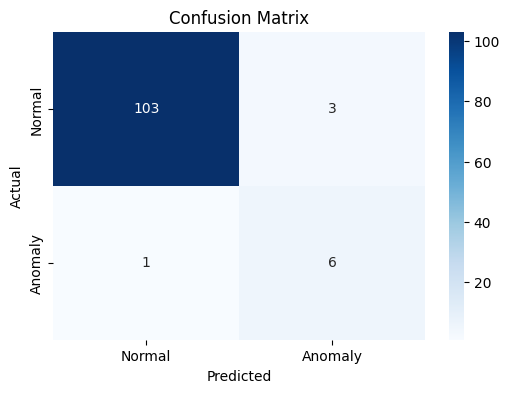


🧠 건강 점수 (SVM 기반): 60.55 / 100
🟢 예측 결과: 정상(normal)으로 감지되었습니다.


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# ------------------ SVM 훈련 ------------------
# 특성과 라벨 정의
X = features_scaled
y = (data["Anomaly_Label"] == -1).astype(int)  # 이상: 1, 정상: 0

# 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# ✅ SVM 분류기 (확률 출력 가능하도록)
svm_clf = SVC(kernel='rbf', gamma='scale', probability=True, random_state=42)
svm_clf.fit(X_train, y_train)

# 예측
y_pred = svm_clf.predict(X_test)

# 평가 출력
print("Classification Report:")
print(classification_report(y_test, y_pred))

# 혼동 행렬
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap="Blues", xticklabels=["Normal", "Anomaly"], yticklabels=["Normal", "Anomaly"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# ------------------ 예시 예측 ------------------
# 예시 입력 데이터
example_input = {
    "Sleep Duration": 6.5,
    "BMI Category": "Normal",  # Normal / Overweight / Obese
    "Blood Pressure": "120/80",
    "Heart Rate": 88,
    "Daily Steps": 6000
}

# 1. 데이터프레임 변환
example_df = pd.DataFrame([example_input])

# 2. 혈압 분리
example_df[["Systolic", "Diastolic"]] = example_df["Blood Pressure"].str.split("/", expand=True).astype(float)
example_df.drop("Blood Pressure", axis=1, inplace=True)

# 3. BMI 원-핫 인코딩
example_df = pd.get_dummies(example_df, columns=["BMI Category"], drop_first=True)
for col in [col for col in features.columns if 'BMI Category_' in col]:
    if col not in example_df.columns:
        example_df[col] = 0
example_df = example_df[features.columns]

# 4. 정규화
example_scaled = scaler.transform(example_df)

# 5. SVM 예측 + 건강 점수 계산
proba = svm_clf.predict_proba(example_scaled)[0]     # [정상확률, 이상확률]
anomaly_prob = proba[1]                              # 이상일 확률
health_score = round((1 - anomaly_prob) * 100, 2)    # 건강 점수 (정상 확률 * 100)

# 6. 최종 예측 결과 출력
prediction = svm_clf.predict(example_scaled)[0]
print(f"\n건강 점수 (SVM 기반): {health_score} / 100")
if prediction == 1:
    print("예측 결과: 이상(anomaly)으로 감지되었습니다.")
else:
    print("예측 결과: 정상(normal)으로 감지되었습니다.")